Abstraction:

In last project, we have explained the significance of developing a program that can accurately detect the presence or absence of face masks in images or videos, so that we can potentially automate the process of monitoring mask-wearing compliance in public spaces, workplaces, and other settings. However, the pre-trained model based on face detection may not regonize faces with mask. In this case, we finetuned FasterRCNN from torchvision trained by labeled images of people wearing masks or not, and used it to automatically detect masks in real-time video.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

from collections import Counter
import matplotlib.patches as mpatches

In [2]:
print(torch.__version__)

1.8.1+cu111


In [3]:
torch.cuda.is_available()

True

In [4]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    elif obj.find('name').text == "without_mask":
        return 0
    

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

We defines three functions for generating object detection targets in PyTorch, based on an input XML file that contains information about bounding boxes and labels for objects in an image.

In [5]:
imgs = list(sorted(os.listdir("D:\Desktop\mask\data/images/")))
labels = list(sorted(os.listdir("D:\Desktop\mask\data/annotations/")))
path_annotations="D:\Desktop\mask\data/annotations/"
path_images="D:\Desktop\mask\data/images/"

In [6]:
img_names=[]
xml_names=[]
for dirname, _, filenames in os.walk('D:\Desktop\mask\data'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [7]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("D:\Desktop\mask\data/images/")))
        self.labels = list(sorted(os.listdir("D:\Desktop\mask\data/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("D:\Desktop\mask\data/images/", file_image)
        label_path = os.path.join("D:\Desktop\mask\data/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
data_transform = transforms.Compose([
        #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        #transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply random color jitter
        #transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
        #transforms.RandomCrop((224, 224))
        transforms.ToTensor(), 
    ])

In [9]:
data_transform_2 = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply random color jitter
        transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
        #transforms.RandomCrop((224, 224))
        transforms.ToTensor(), 
    ])

We loaded images and their corresponding annotations (in XML format) for a face mask detection task. The class takes a transforms to convert image to tensor. We add different data augmentation to see what happen.

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [11]:

dataset = MaskDataset(data_transform)


In [12]:
imgs,annotations = dataset[0]

In [13]:
print(imgs.shape)
print(annotations)

torch.Size([3, 366, 512])
{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0]), 'image_id': tensor([0])}


In [52]:
print(imgs)

tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
         [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
         [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
         ...,
         [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
         [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
         [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],

        [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
         [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
         [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
         ...,
         [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
         [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
         [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],

        [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
         [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
         [0.3647, 0.3451, 0.3137,  ..., 0.3529, 0.4118, 0.

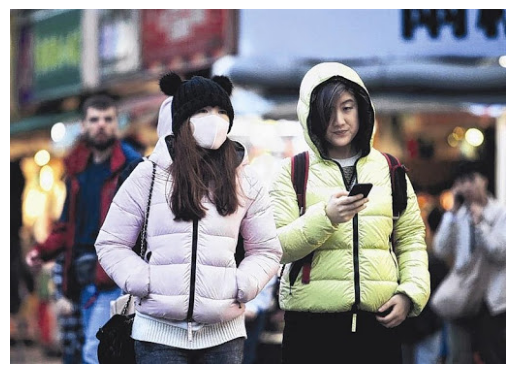

In [14]:
image_numpy = imgs.numpy()
image_numpy = (image_numpy * 255).astype('uint8')
plt.imshow(image_numpy.transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [15]:
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [16]:
for data in data_loader:
    imgs, targets = data
    for i, tensor in enumerate(imgs):

        print(f"Tensor {i+1} shape: {tensor.shape}")
    print(targets)

    break

Tensor 1 shape: torch.Size([3, 366, 512])
Tensor 2 shape: torch.Size([3, 156, 400])
Tensor 3 shape: torch.Size([3, 290, 400])
Tensor 4 shape: torch.Size([3, 271, 400])
({'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0]), 'image_id': tensor([0])}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]), 'image_id': tensor([1])}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]]), 'labels': tensor([1, 1, 1, 2]), 'image_id': tensor([2])}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53., 

In [54]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("D:\Desktop\Project_object_detection\logs")

for epoch in range(2):
    step = 0
    for imgs, annotations in data_loader:
        batch_size = len(imgs)
        height = max([t.size(1) for t in imgs])
        width = max([t.size(2) for t in imgs])
        device = imgs[0].device
        imgs = torch.zeros(batch_size, 3, height, width, dtype=torch.float32, device=device)
        for i, tensor in enumerate(imgs):
            imgs[i, :, : tensor.shape[1], : tensor.shape[2]] = tensor
        writer.add_images("Epoch: {}".format(epoch), imgs, step)
        step = step + 1
writer.close()


We tried to show the images in data loader on tensorboard but unfortunately the images are all black. Usually the reason is the incorrect format of input images, which is required of "NCHW". But we didn't figure out how to fix it.

This function returns an instance segmentation model with a specified number of classes. The model is loaded with a pre-trained Faster R-CNN (Region-based Convolutional Neural Network) backbone, which is trained on the COCO dataset. The head of the model (the box predictor) is replaced with 3 classes.

In [17]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [18]:
model = get_model_instance_segmentation(3)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

The Faster R-CNN (Region-based Convolutional Neural Network) architecture consists of three main components:

Backbone network: This is typically a pre-trained convolutional neural network (CNN) that extracts features from the input image. Common choices for the backbone network include ResNet, VGG, and MobileNet.

Region Proposal Network (RPN): This is a small network that is responsible for generating region proposals (bounding boxes) in the input image. The RPN takes the feature maps generated by the backbone network as input and generates proposals based on anchor boxes and their corresponding objectness scores.

Region-based CNN (RCNN): This is the final stage of the Faster R-CNN architecture, where RoI (Region of Interest) pooling or RoI align is used to extract fixed-size feature vectors from the region proposals generated by the RPN. These feature vectors are then passed through a fully connected network (also known as the head) to predict the class labels and refine the bounding box coordinates of the objects within the region proposals.

In [20]:
num_epochs = 15
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)


### Training with data without augmentation

In [23]:
#writer = SummaryWriter("D:\Desktop\Project_object_detection\logs\logs1")
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
        #writer.add_scalar("Loss/train", epoch_loss, epoch)
    print(epoch_loss)
#writer.close()

tensor(87.1278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(61.1206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(56.1078, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.4219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.0816, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.5480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.5567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.1180, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.3461, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.3940, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.6255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.3391, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.3788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.8571, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.3707, device='cuda:0', grad_fn=<AddBackward0>)


NameError: name 'writer' is not defined

In [24]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [85]:
# model2 = get_model_instance_segmentation(3)
# model2.load_state_dict(torch.load('D:\Desktop\Project_object_detection\models/model_fasterrcnn_resnet50_fpn.pt'))

<All keys matched successfully>

In [26]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [27]:
preds = model([imgs[0]])

In [28]:
preds = [{k: v.detach().cpu() for k, v in detection.items()} for detection in preds]

The function below shows the boxes of original annotations and predictions

In [91]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [295]:
def face_cas(img):
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_images+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

In [29]:
#edgecolor of different color for different class
def plot_face_mask_scores(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box, label,scores in zip(annotation["boxes"], annotation["labels"],annotation["scores"]):
        xmin, ymin, xmax, ymax = box
        score = round(scores.item(),2)
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
        if label == 1:
            ax.text(xmin, ymin, "Mask:"+str(score), color='g')
        elif label == 2:
            ax.text(xmax, ymax, "Incorrect Mask:"+str(score), color='y')
        else:
            ax.text(xmin, ymin, "No Mask:"+str(score), color='r')
            
        #ax.text(xmin, ymin, str(score), color='b')

    plt.show()
        


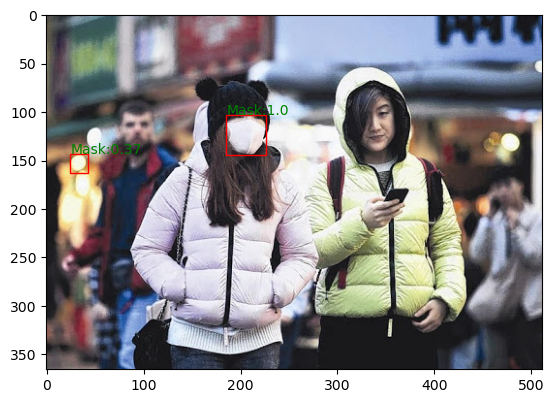

In [30]:
plot_face_mask_scores(imgs[0], preds[0])

In [23]:
torch.save(model.state_dict(),'D:\Desktop\Project_object_detection\models/model_fasterrcnn_resnet50_fpn.pt')

### Training data with augmentation

In [93]:
model_A = get_model_instance_segmentation(3)

In [ ]:
data_transform_2 = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply random color jitter
        transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
        #transforms.RandomCrop((224, 224))
        transforms.ToTensor(), 
    ])

In [94]:
dataset_A = MaskDataset(data_transform_2)
data_loader_A = torch.utils.data.DataLoader(
    dataset_A, batch_size=4, collate_fn=collate_fn)

In [298]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader_A:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break

In [96]:
num_epochs = 15
model_A.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [97]:
params = [p for p in model_A.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader_A)


In [98]:
writer = SummaryWriter("D:\Desktop\Project_object_detection\logs\logs2")
num_epochs = 15
for epoch in range(num_epochs):
    model_A.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model_A([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
        writer.add_scalar("Loss/train", epoch_loss, epoch)
    print(epoch_loss)
writer.close()

tensor(90.3175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(57.6987, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.9725, device='cuda:0', grad_fn=<AddBackward0>)
tensor(45.3165, device='cuda:0', grad_fn=<AddBackward0>)
tensor(40.8282, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.2827, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.5960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.2408, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.9359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.4254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.0387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.2796, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.9476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.9147, device='cuda:0', grad_fn=<AddBackward0>)


We calculate the sum of losses from each batches and compute their gradients. We can see from graph how the losses accumulates. The first graph is produced by training data without data augmentation. In 15 epoches, the first training process takes 39 min, whlie the second one takes 37 min. This may illustrate that data augmentation may increase model robustness and performance while save the time of training.

![loss without augmentation](loss1.png)

![loss with augmentation](loss2.png)

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [99]:
torch.save(model_A.state_dict(),'D:\Desktop\Project_object_detection\models/model_fasterrcnn_resnet50_fpn_2.pt')

## Load model

In [13]:
model2 = get_model_instance_segmentation(3)

In [14]:
model2.load_state_dict(torch.load('D:\Desktop\Project_object_detection\models/model_fasterrcnn_resnet50_fpn.pt'))

<All keys matched successfully>

In [15]:
model2.eval

<bound method Module.eval of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps

In [107]:
device = torch.device('cpu')
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [108]:
preds = model2(imgs)

In [110]:
preds = [{k: v.detach().cpu() for k, v in detection.items()} for detection in preds]

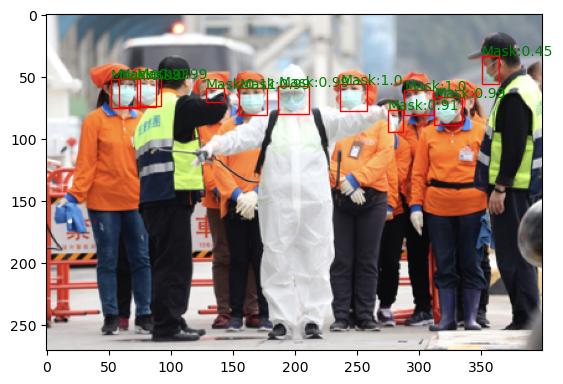

In [112]:
plot_face_mask_scores(imgs[3], preds[3])

Test on the image not in dataset

In [31]:
test_img = Image.open("D:\Desktop\Project_object_detection/test.jpg")

In [32]:
transform = transforms.Compose([transforms.ToTensor()])
test_tensor = transform(test_img)

In [39]:
test_pred = model([test_tensor.to(device)])

In [37]:
device = torch.device('cpu')
model1 = model.to(device)

In [43]:
torch.save(model.state_dict(), 'D:\Desktop\Client/model_fasterrcnn_resnet50_fpn.pth')

In [40]:
test_pred = model1([test_tensor.to(device)])

In [41]:
test_pred = [{k: v.detach().cpu() for k, v in detection.items()} for detection in test_pred]

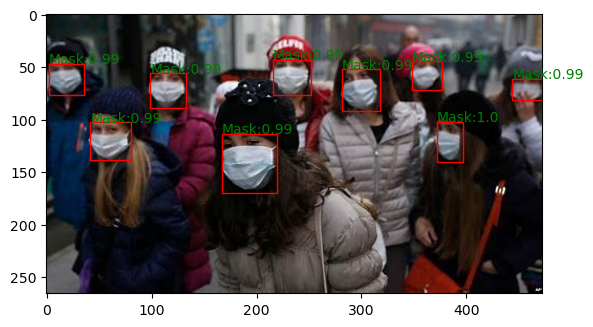

In [42]:
plot_face_mask_scores(test_tensor, test_pred[0])

## mAP

mAP stands for "mean Average Precision". It is a widely used metric in object detection and computer vision tasks to evaluate the performance of algorithms in detecting objects within an image

In [45]:
def insert_over_union(boxes_preds,boxes_labels):
    
    box1_x1=boxes_preds[...,0:1]
    box1_y1=boxes_preds[...,1:2]
    box1_x2=boxes_preds[...,2:3]
    box1_y2=boxes_preds[...,3:4]#shape:[N,1]
    
    box2_x1=boxes_labels[...,0:1]
    box2_y1=boxes_labels[...,1:2]
    box2_x2=boxes_labels[...,2:3]
    box2_y2=boxes_labels[...,3:4]
    
    x1=torch.max(box1_x1,box2_x1)
    y1=torch.max(box1_y1,box2_y1)
    x2=torch.min(box1_x2,box2_x2)
    y2=torch.min(box1_y2,box2_y2)
    
    intersection=(x2-x1).clamp(0)*(y2-y1).clamp(0)
    
    box1_area=abs((box1_x2-box1_x1)*(box1_y1-box1_y2))
    box2_area=abs((box2_x2-box2_x1)*(box2_y1-box2_y2))
    
    return intersection/(box1_area+box2_area-intersection+1e-6)


In [44]:
from collections import Counter
 
def mean_average_precision(pred_bboxes,true_boxes,iou_threshold,num_classes=3):
    
    #pred_bboxes(list): [[train_idx,class_pred,prob_score,x1,y1,x2,y2], ...]
    
    average_precisions=[]#save AP for each class
    epsilon=1e-6#prevent division by zero
    
    #for each class
    for c in range(num_classes):
        detections=[]#store all the predicted bboxes of this class
        ground_truths=[]#store all the true bboxes of this class
        
        for detection in pred_bboxes:
            if detection[1]==c:
                detections.append(detection)
        
        for true_box in true_boxes:
            if true_box[1]==c:
                ground_truths.append(true_box)
                
        #img 0 has 3 bboxes
        #img 1 has 5 bboxes
        
        #count the amount of bboxes for each image
        amount_bboxes=Counter(gt[0] for gt in ground_truths)
        
        for key,val in amount_bboxes.items():
            amount_bboxes[key]=torch.zeros(val)#initialize the amount_bboxes with 0
        #amount_bboxes={0:torch.tensor([0,0,0]),1:torch.tensor([0,0,0,0,0])}
        
        #sort the detections by the prob_score, from high to low
        detections.sort(key=lambda x:x[2],reverse=True)
        
        #initialize the TP and FP
        TP=torch.zeros(len(detections))
        FP=torch.zeros(len(detections))
        
        #TP+FN is the total amount of bboxes of this class
        total_true_bboxes=len(ground_truths)
        
        #if there is no bbox of this class in the image, then skip this class
        if total_true_bboxes == 0:
            continue
        
        #for each detection, calculate the IoU with all the ground truth bboxes
        for detection_idx,detection in enumerate(detections):

            #find the ground truth bboxes of the image that the detection is in
            ground_truth_img=[bbox for bbox in ground_truths if bbox[0]==detections[0]]
            
            num_gts=len(ground_truth_img)
            
            best_iou=0
            for idx,gt in enumerate(ground_truth_img):
                #calculate the IoU
                iou=insert_over_union(torch.tensor(detection[3:]),torch.tensor(gt[2:]))
                if iou >best_iou:
                    best_iou=iou
                    best_gt_idx=idx
            if best_iou>iou_threshold:
                
                if amount_bboxes[detection[0]][best_gt_idx]==0:
                    TP[detection_idx]=1
                    amount_bboxes[detection[0]][best_gt_idx]=1
                else:
                    FP[detection_idx]=1
            else:
                FP[detection_idx]=1
                
        TP_cumsum=torch.cumsum(TP,dim=0)
        FP_cumsum=torch.cumsum(FP,dim=0)
        
        
        recalls=TP_cumsum/(total_true_bboxes+epsilon)
        precisions=torch.divide(TP_cumsum,(TP_cumsum+FP_cumsum+epsilon))
        
       
        precisions=torch.cat((torch.tensor([1]),precisions))
        recalls=torch.cat((torch.tensor([0]),recalls))
       
        average_precisions.append(torch.trapz(precisions,recalls))
        
    return sum(average_precisions)/len(average_precisions) 


In [46]:
# calculate mAP for model
def calculate_mAP(model, data_loader):
    model.eval()
    all_predictions = []
    all_annotations = []
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        predictions = model(imgs)
        predictions = [{k: v.detach().cpu() for k, v in detection.items()} for detection in predictions]
        
        all_predictions.append(predictions)
        all_annotations.append(annotations)
    return all_predictions, all_annotations

In [141]:
imgs = list(img.to(device) for img in imgs)
annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
predictions = model2(imgs)
predictions = [{k: v.detach().cpu() for k, v in detection.items()} for detection in predictions]

In [142]:
annotations

[{'boxes': tensor([[ 79., 105., 109., 142.],
          [185., 100., 226., 144.],
          [325.,  90., 360., 141.]]),
  'labels': tensor([0, 1, 0]),
  'image_id': tensor([0])},
 {'boxes': tensor([[321.,  34., 354.,  69.],
          [224.,  38., 261.,  73.],
          [299.,  58., 315.,  81.],
          [143.,  74., 174., 115.],
          [ 74.,  69.,  95.,  99.],
          [191.,  67., 221.,  93.],
          [ 21.,  73.,  44.,  93.],
          [369.,  70., 398.,  99.],
          [ 83.,  56., 111.,  89.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]),
  'image_id': tensor([1])},
 {'boxes': tensor([[ 68.,  42., 105.,  69.],
          [154.,  47., 178.,  74.],
          [238.,  34., 262.,  69.],
          [333.,  31., 366.,  65.]]),
  'labels': tensor([1, 1, 1, 2]),
  'image_id': tensor([2])},
 {'boxes': tensor([[ 52.,  53.,  73.,  76.],
          [ 72.,  53.,  92.,  75.],
          [112.,  51., 120.,  68.],
          [155.,  60., 177.,  83.],
          [189.,  59., 210.,  80.],
    

In [147]:
#pred_bboxes(list): [[image_id,class_pred,scores,x1,y1,x2,y2], ...]
#true_boxes(list): [[image_id,class_pred,x1,y1,x2,y2], ...]

In [191]:
pred_bboxes=[]
for i in range(len(predictions)):
    pred_boxes=[]
    for j in range(len(predictions[i]['boxes'])):
        pred_boxes.extend([i,predictions[i]['labels'][j],predictions[i]['scores'][j],predictions[i]['boxes'][j][0],predictions[i]['boxes'][j][1],predictions[i]['boxes'][j][2],predictions[i]['boxes'][j][3]])
    pred_bboxes.append(pred_boxes)


In [198]:

for i in range(len(pred_bboxes)):
    for j in range(len(pred_bboxes[i])):
        if isinstance(pred_bboxes[i][j], torch.Tensor):
           pred_bboxes[i][j] = pred_bboxes[i][j].item()

In [235]:
pred_bboxes

[[0,
  1,
  0.992176353931427,
  185.00306701660156,
  99.3744125366211,
  228.94398498535156,
  144.95046997070312],
 [1,
  1,
  0.9940485954284668,
  223.9722442626953,
  36.963871002197266,
  260.8827209472656,
  72.53575134277344,
  1,
  1,
  0.9934485554695129,
  319.44158935546875,
  32.58098220825195,
  354.24713134765625,
  70.10057067871094,
  1,
  1,
  0.9891997575759888,
  22.622211456298828,
  72.8399429321289,
  43.47585678100586,
  92.07245635986328,
  1,
  1,
  0.9877713918685913,
  196.14720153808594,
  65.48484802246094,
  216.87677001953125,
  93.2220687866211,
  1,
  1,
  0.9865589141845703,
  298.1529541015625,
  59.62606430053711,
  314.4937438964844,
  77.89816284179688,
  1,
  1,
  0.9793548583984375,
  142.08889770507812,
  72.9007568359375,
  173.89303588867188,
  112.67256164550781,
  1,
  2,
  0.5153540372848511,
  80.9900894165039,
  53.549102783203125,
  112.30990600585938,
  87.55482482910156,
  1,
  1,
  0.4562506079673767,
  369.16668701171875,
  68.5059

In [236]:
pred_bboxes=[elem for sublist in pred_bboxes for elem in sublist]

In [237]:
pred_bboxes=[pred_bboxes[i:i+7] for i in range(0,len(pred_bboxes),7)]

In [238]:
pred_bboxes

[[0,
  1,
  0.992176353931427,
  185.00306701660156,
  99.3744125366211,
  228.94398498535156,
  144.95046997070312],
 [1,
  1,
  0.9940485954284668,
  223.9722442626953,
  36.963871002197266,
  260.8827209472656,
  72.53575134277344],
 [1,
  1,
  0.9934485554695129,
  319.44158935546875,
  32.58098220825195,
  354.24713134765625,
  70.10057067871094],
 [1,
  1,
  0.9891997575759888,
  22.622211456298828,
  72.8399429321289,
  43.47585678100586,
  92.07245635986328],
 [1,
  1,
  0.9877713918685913,
  196.14720153808594,
  65.48484802246094,
  216.87677001953125,
  93.2220687866211],
 [1,
  1,
  0.9865589141845703,
  298.1529541015625,
  59.62606430053711,
  314.4937438964844,
  77.89816284179688],
 [1,
  1,
  0.9793548583984375,
  142.08889770507812,
  72.9007568359375,
  173.89303588867188,
  112.67256164550781],
 [1,
  2,
  0.5153540372848511,
  80.9900894165039,
  53.549102783203125,
  112.30990600585938,
  87.55482482910156],
 [1,
  1,
  0.4562506079673767,
  369.16668701171875,
  

In [151]:
true_boxes=[]
for i in range(len(annotations)):
    true_boxes.extend([[i,annotations[i]['labels'][j],annotations[i]['boxes'][j][0],annotations[i]['boxes'][j][1],annotations[i]['boxes'][j][2],annotations[i]['boxes'][j][3]] for j in range(len(annotations[i]['boxes']))])
    

In [202]:
for i in range(len(true_boxes)):
    for j in range(len(true_boxes[i])):
        if isinstance(true_boxes[i][j], torch.Tensor):
           true_boxes[i][j] = true_boxes[i][j].item()

In [224]:
true_boxes

[[0, 0, 79.0, 105.0, 109.0, 142.0],
 [0, 1, 185.0, 100.0, 226.0, 144.0],
 [0, 0, 325.0, 90.0, 360.0, 141.0],
 [1, 1, 321.0, 34.0, 354.0, 69.0],
 [1, 1, 224.0, 38.0, 261.0, 73.0],
 [1, 1, 299.0, 58.0, 315.0, 81.0],
 [1, 1, 143.0, 74.0, 174.0, 115.0],
 [1, 1, 74.0, 69.0, 95.0, 99.0],
 [1, 1, 191.0, 67.0, 221.0, 93.0],
 [1, 1, 21.0, 73.0, 44.0, 93.0],
 [1, 1, 369.0, 70.0, 398.0, 99.0],
 [1, 0, 83.0, 56.0, 111.0, 89.0],
 [2, 1, 68.0, 42.0, 105.0, 69.0],
 [2, 1, 154.0, 47.0, 178.0, 74.0],
 [2, 1, 238.0, 34.0, 262.0, 69.0],
 [2, 2, 333.0, 31.0, 366.0, 65.0],
 [3, 1, 52.0, 53.0, 73.0, 76.0],
 [3, 1, 72.0, 53.0, 92.0, 75.0],
 [3, 1, 112.0, 51.0, 120.0, 68.0],
 [3, 1, 155.0, 60.0, 177.0, 83.0],
 [3, 1, 189.0, 59.0, 210.0, 80.0],
 [3, 1, 235.0, 57.0, 257.0, 78.0],
 [3, 1, 289.0, 60.0, 309.0, 83.0],
 [3, 1, 313.0, 68.0, 333.0, 90.0],
 [3, 1, 351.0, 35.0, 364.0, 59.0]]

Calculate the ap for classes 1 "with mask"

In [308]:
c=1
iou_threshold=0.9
epsilon=1e-6

In [239]:
c=1
detections=[]#store all the predicted bboxes of this class
ground_truths=[]#store all the true bboxes of this class

for detection in pred_bboxes:
    if detection[1]==c:
        detections.append(detection)

for true_box in true_boxes:
    if true_box[1]==c:
        ground_truths.append(true_box)

In [228]:
ground_truths

[[0, 1, 185.0, 100.0, 226.0, 144.0],
 [1, 1, 321.0, 34.0, 354.0, 69.0],
 [1, 1, 224.0, 38.0, 261.0, 73.0],
 [1, 1, 299.0, 58.0, 315.0, 81.0],
 [1, 1, 143.0, 74.0, 174.0, 115.0],
 [1, 1, 74.0, 69.0, 95.0, 99.0],
 [1, 1, 191.0, 67.0, 221.0, 93.0],
 [1, 1, 21.0, 73.0, 44.0, 93.0],
 [1, 1, 369.0, 70.0, 398.0, 99.0],
 [2, 1, 68.0, 42.0, 105.0, 69.0],
 [2, 1, 154.0, 47.0, 178.0, 74.0],
 [2, 1, 238.0, 34.0, 262.0, 69.0],
 [3, 1, 52.0, 53.0, 73.0, 76.0],
 [3, 1, 72.0, 53.0, 92.0, 75.0],
 [3, 1, 112.0, 51.0, 120.0, 68.0],
 [3, 1, 155.0, 60.0, 177.0, 83.0],
 [3, 1, 189.0, 59.0, 210.0, 80.0],
 [3, 1, 235.0, 57.0, 257.0, 78.0],
 [3, 1, 289.0, 60.0, 309.0, 83.0],
 [3, 1, 313.0, 68.0, 333.0, 90.0],
 [3, 1, 351.0, 35.0, 364.0, 59.0]]

In [13]:
detections

NameError: name 'detections' is not defined

In [243]:
amount_bboxes=Counter(gt[0] for gt in ground_truths)

for key,val in amount_bboxes.items():
    amount_bboxes[key]=torch.zeros(val)#initialize the amount_bboxes with 0
#amount_bboxes={0:torch.tensor([0,0,0]),1:torch.tensor([0,0,0,0,0])}

#sort the detections by the prob_score, from high to low
detections.sort(key=lambda x:x[2],reverse=True)

In [246]:
TP=torch.zeros(len(detections))
FP=torch.zeros(len(detections))

#TP+FN is the total amount of bboxes of this class
total_true_bboxes=len(ground_truths)

#if there is no bbox of this class in the image, then skip this class
# if total_true_bboxes == 0:
#     continue

In [328]:
ground_truth_img=[bbox for bbox in ground_truths if bbox[0]==detections[0][0]]
ground_truth_img

[[2, 1, 68.0, 42.0, 105.0, 69.0],
 [2, 1, 154.0, 47.0, 178.0, 74.0],
 [2, 1, 238.0, 34.0, 262.0, 69.0]]

In [329]:
for detection_idx,detection in enumerate(detections):
    #find the ground truth bboxes of the image that the detection is in
    ground_truth_img=[bbox for bbox in ground_truths if bbox[0]==detections[0][0]]
    
    num_gts=len(ground_truth_img)
        
    best_iou=0
    for idx,gt in enumerate(ground_truth_img):
        #calculate the IoU
        iou=insert_over_union(torch.tensor(detection[3:]),torch.tensor(gt[3:]))
        print(iou)
        


tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])


In [309]:
for detection_idx,detection in enumerate(detections):

    #find the ground truth bboxes of the image that the detection is in
    ground_truth_img=[bbox for bbox in ground_truths if bbox[0]==detections[0][0]]
    
    num_gts=len(ground_truth_img)
    
    best_iou=0
    for idx,gt in enumerate(ground_truth_img):
        #calculate the IoU
        iou=insert_over_union(torch.tensor(detection[3:]),torch.tensor(gt[2:]))
        if iou >best_iou:
            best_iou=iou
            best_gt_idx=idx
    if best_iou>iou_threshold:
        
        if amount_bboxes[detection[0]][best_gt_idx]==0:
            TP[detection_idx]=1
            amount_bboxes[detection[0]][best_gt_idx]=1
        else:
            FP[detection_idx]=1
    else:
        FP[detection_idx]=1

In [310]:
#False positive
FP

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])

In [311]:
#True positive
TP

tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0.])

In [276]:
average_precisions=[]
TP_cumsum=torch.cumsum(TP,dim=0)
FP_cumsum=torch.cumsum(FP,dim=0)


recalls=TP_cumsum/(total_true_bboxes+epsilon)
precisions=torch.divide(TP_cumsum,(TP_cumsum+FP_cumsum+epsilon))


precisions=torch.cat((torch.tensor([1]),precisions))
recalls=torch.cat((torch.tensor([0]),recalls))

average_precisions.append(torch.trapz(precisions,recalls))
        

In [283]:
recalls

tensor([0.0000, 0.0476, 0.0476, 0.0952, 0.0952, 0.0952, 0.1429, 0.1429, 0.1429,
        0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1905,
        0.1905, 0.1905, 0.1905, 0.1905, 0.1905, 0.1905, 0.1905])

In [284]:
precisions

tensor([1.0000, 0.5000, 0.3333, 0.4000, 0.3333, 0.2857, 0.3333, 0.3000, 0.2727,
        0.2500, 0.2308, 0.2143, 0.2000, 0.1875, 0.1765, 0.1667, 0.1579, 0.1905,
        0.1818, 0.1739, 0.1667, 0.1600, 0.1538, 0.1481, 0.1429])

In [280]:
average_precisions

[tensor(0.0762)]

The ap of mask seems really low here.

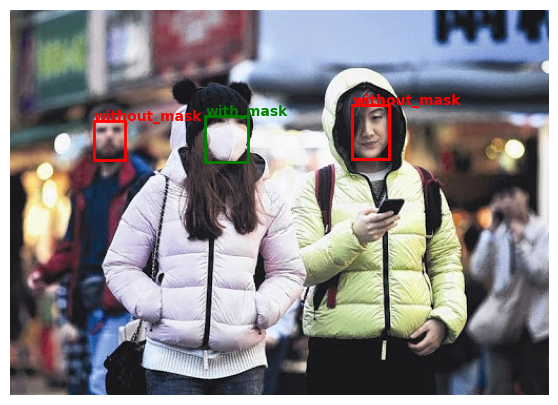

In [322]:
face_cas(img_names[0])

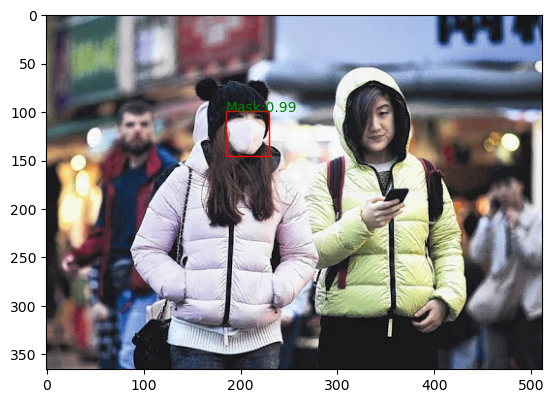

In [324]:
plot_face_mask_scores(imgs[0],preds[0])

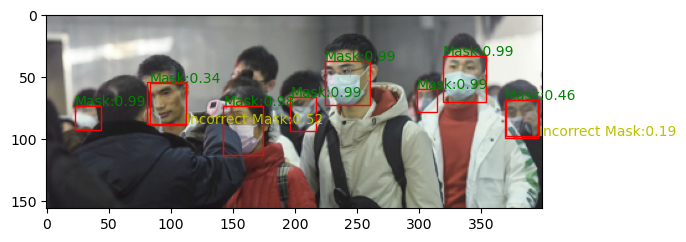

In [325]:
plot_face_mask_scores(imgs[1],preds[1])

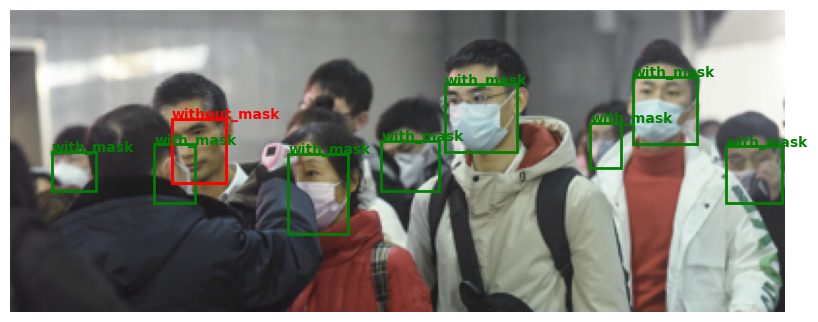

In [326]:
face_cas(img_names[1])

## Conclusion

In this model, the model has a better performance in detecting the mask and giving the confidence. 

Reference:
https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn/notebook
https://www.kaggle.com/code/tingsongou/finetuning-fasterrcnn-for-mask-detection-pytorch
https://www.kaggle.com/code/gokifujiya/face-mask-object-detection-retinanet-xml-file